<a href="https://colab.research.google.com/github/esintao/Konrad-og-Esin/blob/main/Chain_of_thought.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset
from transformers import pipeline

# Load model

In [2]:
prompt = "Write an email about an alpaca that likes flan"

model = pipeline(task="text2text-generation", model="google/flan-t5-base")

model(prompt, max_length=128, do_sample=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "I've got an alpaca that likes flan. It's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear. He's a teddy bear."}]

# Load dataset

In [3]:
import pandas as pd

In [4]:
dataset = load_dataset("derek-thomas/ScienceQA")

df = pd.DataFrame.from_dict(dataset['train'])

df = df[(df['choices'].str.len() == 4) & (df['image'].isna())]

df = df.sample(n=200)



README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1028f23e353fbe(…):   0%|          | 0.00/377M [00:00<?, ?B/s]

data/validation-00000-of-00001-6c7328ff6(…):   0%|          | 0.00/126M [00:00<?, ?B/s]

data/test-00000-of-00001-f0e719df791966f(…):   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

# Prompting without CoT

In [5]:
df['baseline_result'] = pd.NA
df['correct/incorrect'] = pd.NA



for i, row in df.iterrows():
    question_text = (
        f"Question: {row['question']}\n"
        f"(A) {row['choices'][0]} "
        f"(B) {row['choices'][1]} "
        f"(C) {row['choices'][2]} "
        f"(D) {row['choices'][3]}"
        f"The answer must be formatted as 1 letter, A-D."
    )

    baseline_result = model(question_text, max_new_tokens=5, temperature=0.1, do_sample=False)

    generated = baseline_result[0]['generated_text']

    df.loc[i, 'baseline_result'] = generated


df['predicted_letter'] = (df['baseline_result'].str.extract(r'\b([ABCD])\b', expand=False))

df['gold_letter'] = df['answer'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

df['correct/incorrect'] = (df['predicted_letter'] == df['gold_letter']).astype('Int64')


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [6]:
df

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter
4446,None,How long is a tennis racket?,"[25 feet, 25 yards, 25 inches, 25 miles]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Units and measurement,"Choose customary units of distance, mass, and ...",Measurements are written with both a number an...,The best estimate for the length of a tennis r...,(A),0,A,C
30,None,Select the living thing.,"[teddy bear, amoebae, van, kite]",1,,closed choice,grade4,natural science,biology,Classification,Identify living and nonliving things,All living things are made up of cells. Plants...,A teddy bear is not a living thing.\nTeddy bea...,B,1,B,B
9212,None,"According to the Fourth Amendment, when is a j...",[when the judge has a good reason to believe s...,0,A search warrant is a piece of paper that give...,closed choice,grade4,social science,civics,Government,The Bill of Rights,,A judge is allowed to write a search warrant w...,A,1,A,A
8109,None,What do these two changes have in common?\nrus...,"[Both are caused by cooling., Both are chemica...",1,,closed choice,grade8,natural science,chemistry,Chemical reactions,Compare physical and chemical changes,Matter is made of very small particles called ...,Step 1: Think about each change.\nRust forming...,(B),1,B,B
11527,None,Select the solid.,"[fruit punch, coffee, rain puddle, beads]",3,,closed choice,grade3,natural science,physics,States of matter,"Identify solids, liquids, and gases","Solid, liquid, and gas are states of matter. M...",Coffee is a liquid. A liquid takes the shape o...,A,0,A,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,None,How long is a parking space?,"[20 inches, 20 miles, 20 yards, 20 feet]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,"Choose customary units of distance, mass, and ...",Measurements are written with both a number an...,The best estimate for the length of a parking ...,D,1,D,D
532,None,Select the plant.,"[Wombats eat plants., Wolves eat animals., Dah...",2,,closed choice,grade3,natural science,biology,Classification,Identify plants and animals,Plants and animals are living things. Living t...,A wombat is an animal. It eats plants.\nWombat...,C,1,C,C
8326,None,Select the living thing.,"[pushpin, stop sign, boulder, barnacle]",3,,closed choice,grade4,natural science,biology,Classification,Identify living and nonliving things,All living things are made up of cells. Plants...,A pushpin is not a living thing.\nPushpins do ...,D,1,D,D
6272,None,How long is the Grand Canyon?,"[275 feet, 275 inches, 275 yards, 275 miles]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,"Choose customary units of distance, mass, and ...",Measurements are written with both a number an...,The best estimate for the length of the Grand ...,D,1,D,D


# Prompting with CoT

In [10]:
answers_CoT = []
question_list_CoT = []

# 1. Define a template with a "Few-Shot" example
FEW_SHOT_EXAMPLE = """You are a careful reasoning assistant that answers multiple-choice questions about science.
First, think step by step. Then, give the final answer.

Example Question: What is the main source of energy for Earth?
(A) The Moon (B) The Sun (C) Burning coal (D) Wind
Reasoning: Step 1: Earth's climate and life processes require a massive constant energy source.
Reasoning: Step 2: While wind and coal provide energy, they are secondary sources.
Reasoning: Step 3: The Sun provides the vast majority of energy to Earth via radiation.
Answer: B

---
"""


answers_CoT = []

for i, row in df.iterrows():
    # 2. Construct the prompt with clear newlines and the example
    prompt = (
            "You are a careful reasoning assistant that answers multiple-choice questions about science. "
            "First, think step by step. Then, give the final answer. "
            "Format exactly as:\n"
            "Reasoning: <step 1>\n"
            "Reasoning: <step 2>\n"
            "Reasoning: <step 3>\n"
            "Answer: <final letter>\n\n"
            f"Question: {row['question']}\n"
            f"Options: (A) {row['choices'][0]} (B) {row['choices'][1]} (C) {row['choices'][2]} (D) {row['choices'][3]}\n\n"
            "Reasoning:"
        )

    CoT_result = model(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, repetition_penalty=2.5)

    # We prepend "Reasoning:" back to the text since we used it as a nudge
    generated_text = "Reasoning:" + CoT_result[0]['generated_text']
    df.loc[i,'CoT_result'] = generated_text
    answers_CoT.append(generated_text)
    question_list_CoT.append(prompt)

pattern = r"Reasoning:\s*(.*?)\s*The final answer:\s*\(?([A-D])\)?"
df[['reasoning', 'predicted_letter_CoT']] = df['CoT_result'].str.extract(pattern)

df['correct/incorrect_CoT'] = (df['predicted_letter_CoT'] == df['gold_letter']).astype('Int64')



KeyboardInterrupt: 

In [8]:
df

,image,question,choices,answer,hint,task,grade,subject,topic,category,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
4446,None,How long is a tennis racket?,"[25 feet, 25 yards, 25 inches, 25 miles]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Units and measurement,...,Measurements are written with both a number an...,The best estimate for the length of a tennis r...,(A),0,A,C,Reasoning:A tennis racket is 25 inches long. T...,A tennis racket is 25 inches long.,A,0
30,None,Select the living thing.,"[teddy bear, amoebae, van, kite]",1,,closed choice,grade4,natural science,biology,Classification,...,All living things are made up of cells. Plants...,A teddy bear is not a living thing.\nTeddy bea...,B,1,B,B,Reasoning:Amoebae are the only living things. ...,Amoebae are the only living things.,B,1
9212,None,"According to the Fourth Amendment, when is a j...",[when the judge has a good reason to believe s...,0,A search warrant is a piece of paper that give...,closed choice,grade4,social science,civics,Government,...,,A judge is allowed to write a search warrant w...,A,1,A,A,Reasoning:A judge can write a warrant when the...,A judge can write a warrant when the judge has...,A,1
8109,None,What do these two changes have in common?\nrus...,"[Both are caused by cooling., Both are chemica...",1,,closed choice,grade8,natural science,chemistry,Chemical reactions,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nRust forming...,(B),1,B,B,Reasoning:(B) These two changes have in common...,(B) These two changes have in common rust form...,B,1
11527,None,Select the solid.,"[fruit punch, coffee, rain puddle, beads]",3,,closed choice,grade3,natural science,physics,States of matter,...,"Solid, liquid, and gas are states of matter. M...",Coffee is a liquid. A liquid takes the shape o...,A,0,A,D,Reasoning:Fruit punch is a solid. The final an...,Fruit punch is a solid.,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,None,How long is a parking space?,"[20 inches, 20 miles, 20 yards, 20 feet]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,...,Measurements are written with both a number an...,The best estimate for the length of a parking ...,D,1,D,D,Reasoning:A parking space is 20 feet long. The...,A parking space is 20 feet long.,D,1
532,None,Select the plant.,"[Wombats eat plants., Wolves eat animals., Dah...",2,,closed choice,grade3,natural science,biology,Classification,...,Plants and animals are living things. Living t...,A wombat is an animal. It eats plants.\nWombat...,C,1,C,C,Reasoning:Dahlias can grow colorful flowers. W...,Dahlias can grow colorful flowers. Wombats eat...,C,1
8326,None,Select the living thing.,"[pushpin, stop sign, boulder, barnacle]",3,,closed choice,grade4,natural science,biology,Classification,...,All living things are made up of cells. Plants...,A pushpin is not a living thing.\nPushpins do ...,D,1,D,D,Reasoning:Living things are a group of living ...,Living things are a group of living beings.,D,1
6272,None,How long is the Grand Canyon?,"[275 feet, 275 inches, 275 yards, 275 miles]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Units and measurement,...,Measurements are written with both a number an...,The best estimate for the length of the Grand ...,D,1,D,D,Reasoning:The Grand Canyon is 275 miles long. ...,The Grand Canyon is 275 miles long.,D,1


# Flip analysis

In [12]:
def get_category(row):
    if (row['correct/incorrect'] == 0) and (row['correct/incorrect_CoT'] == 1):
      return "Flip-to-correct"
    elif (row['correct/incorrect'] == 1) and (row['correct/incorrect_CoT'] == 0):
      return "Flip-to-incorrect"
    elif (row['correct/incorrect'] == 1) and (row['correct/incorrect_CoT'] == 1):
      return "Correct–Correct"
    else:
      return "Incorrect–Incorrect"

df['category'] = df.apply(get_category, axis=1)



,image,question,choices,answer,hint,task,grade,subject,topic,category,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
4446,None,How long is a tennis racket?,"[25 feet, 25 yards, 25 inches, 25 miles]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Incorrect–Incorrect,...,Measurements are written with both a number an...,The best estimate for the length of a tennis r...,(A),0,A,C,Reasoning:A tennis racket is 25 inches long. T...,A tennis racket is 25 inches long.,A,0
30,None,Select the living thing.,"[teddy bear, amoebae, van, kite]",1,,closed choice,grade4,natural science,biology,Correct–Correct,...,All living things are made up of cells. Plants...,A teddy bear is not a living thing.\nTeddy bea...,B,1,B,B,Reasoning:Amoebae are the only living things. ...,Amoebae are the only living things.,B,1
9212,None,"According to the Fourth Amendment, when is a j...",[when the judge has a good reason to believe s...,0,A search warrant is a piece of paper that give...,closed choice,grade4,social science,civics,Correct–Correct,...,,A judge is allowed to write a search warrant w...,A,1,A,A,Reasoning:A judge can write a warrant when the...,A judge can write a warrant when the judge has...,A,1
8109,None,What do these two changes have in common?\nrus...,"[Both are caused by cooling., Both are chemica...",1,,closed choice,grade8,natural science,chemistry,Correct–Correct,...,Matter is made of very small particles called ...,Step 1: Think about each change.\nRust forming...,(B),1,B,B,Reasoning:(B) Both are chemical changes. Rust ...,(B) These two changes have in common rust form...,B,1
11527,None,Select the solid.,"[fruit punch, coffee, rain puddle, beads]",3,,closed choice,grade3,natural science,physics,Incorrect–Incorrect,...,"Solid, liquid, and gas are states of matter. M...",Coffee is a liquid. A liquid takes the shape o...,A,0,A,D,Reasoning:Fruit punch is a solid. The final an...,Fruit punch is a solid.,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,None,How long is a parking space?,"[20 inches, 20 miles, 20 yards, 20 feet]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Correct–Correct,...,Measurements are written with both a number an...,The best estimate for the length of a parking ...,D,1,D,D,Reasoning:A parking space is 20 feet long. The...,A parking space is 20 feet long.,D,1
532,None,Select the plant.,"[Wombats eat plants., Wolves eat animals., Dah...",2,,closed choice,grade3,natural science,biology,Correct–Correct,...,Plants and animals are living things. Living t...,A wombat is an animal. It eats plants.\nWombat...,C,1,C,C,Reasoning:Dahlias can grow colorful flowers. W...,Dahlias can grow colorful flowers. Wombats eat...,C,1
8326,None,Select the living thing.,"[pushpin, stop sign, boulder, barnacle]",3,,closed choice,grade4,natural science,biology,Correct–Correct,...,All living things are made up of cells. Plants...,A pushpin is not a living thing.\nPushpins do ...,D,1,D,D,Reasoning:Living things are a group of living ...,Living things are a group of living beings.,D,1
6272,None,How long is the Grand Canyon?,"[275 feet, 275 inches, 275 yards, 275 miles]",3,Select the best estimate.,closed choice,grade7,natural science,units-and-measurement,Correct–Correct,...,Measurements are written with both a number an...,The best estimate for the length of the Grand ...,D,1,D,D,Reasoning:The Grand Canyon is 275 miles long. ...,The Grand Canyon is 275 miles long.,D,1


<Axes: xlabel='category'>

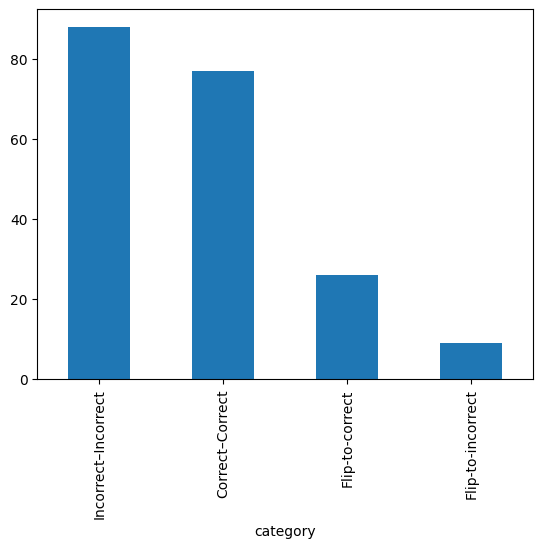

In [20]:
import matplotlib.pyplot as plt

flip_analysis = df['category'].value_counts()

flip_analysis.plot.bar()

In [21]:
incorrect_incorrect = df[df['category'] == "Incorrect–Incorrect"]
correct_correct = df[df['category'] == 'Correct-Correct']
flip_to_correct = df[df['category'] == 'Flip-to-correct']
flip_to_incorrect = df[df['category'] == 'Flip-to-incorrect']



,image,question,choices,answer,hint,task,grade,subject,topic,category,...,lecture,solution,baseline_result,correct/incorrect,predicted_letter,gold_letter,CoT_result,reasoning,predicted_letter_CoT,correct/incorrect_CoT
4446,None,How long is a tennis racket?,"[25 feet, 25 yards, 25 inches, 25 miles]",2,Select the best estimate.,closed choice,grade6,natural science,units-and-measurement,Incorrect–Incorrect,...,Measurements are written with both a number an...,The best estimate for the length of a tennis r...,(A),0,A,C,Reasoning:A tennis racket is 25 inches long. T...,A tennis racket is 25 inches long.,A,0
11527,None,Select the solid.,"[fruit punch, coffee, rain puddle, beads]",3,,closed choice,grade3,natural science,physics,Incorrect–Incorrect,...,"Solid, liquid, and gas are states of matter. M...",Coffee is a liquid. A liquid takes the shape o...,A,0,A,D,Reasoning:Fruit punch is a solid. The final an...,Fruit punch is a solid.,B,0
799,None,Select the reptile.,"[Japanese tree frog, fruit bat, eagle ray, sal...",3,,closed choice,grade5,natural science,biology,Incorrect–Incorrect,...,"Reptiles have scaly, waterproof skin. Most rep...",A fruit bat is a mammal. It has hair and feeds...,A,0,A,D,Reasoning:Japanese tree frog is a reptile. The...,Japanese tree frog is a reptile.,A,0
7780,None,What do these two changes have in common?\nmol...,"[Both are caused by cooling., Both are caused ...",3,,closed choice,grade3,natural science,chemistry,Incorrect–Incorrect,...,Chemical changes and physical changes are two ...,Step 1: Think about each change.\nMolding clay...,(B),0,B,D,Reasoning:Molding clay into the shape of a pot...,Molding clay into the shape of a pot is a chem...,B,0
1066,None,Select the action that doesn't belong.,"[edit, rewrite, multiply, write]",2,,closed choice,grade3,language science,vocabulary,Incorrect–Incorrect,...,,"Multiply doesn't belong.\nRewrite, edit, and w...",B,0,B,C,Reasoning:Action that doesn't belong can be re...,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,None,Which type of sentence is this?\nThe weather f...,"[complex, simple, compound, compound-complex]",2,,closed choice,grade10,language science,grammar,Incorrect–Incorrect,...,A clause is a group of words that contains bot...,The sentence is compound. It is made up of two...,(A),0,A,C,Reasoning:The weather forecast predicted sever...,The weather forecast predicted severe thunders...,A,0
1704,None,Select the solid.,"[fruit punch, garbage can, wet paint, vinegar]",1,,closed choice,grade3,natural science,physics,Incorrect–Incorrect,...,"Solid, liquid, and gas are states of matter. M...",Wet paint is a liquid. A liquid takes the shap...,D,0,D,B,Reasoning:Vinegar is a solid. The final answer...,Vinegar is a solid.,D,0
2754,None,Which word is not like the others?,"[day, week, school, year]",2,,closed choice,grade1,language science,vocabulary,Incorrect–Incorrect,...,Some words are alike. They go together in a gr...,"Day, year, and week go together. They are time...",day,0,NaN,C,Reasoning:Day is not like the others. The fina...,Day is not like the others.,D,0
8685,None,Select the part whose main job is to sort and ...,"[chromosomes, Golgi, nucleus, vacuoles]",1,,closed choice,grade8,natural science,biology,Incorrect–Incorrect,...,Animal cells are made up of many different par...,The Golgi sorts and packages proteins and othe...,chromosomes,0,NaN,B,Reasoning:Chromosomes are part of the nucleus....,Chromosomes are part of the nucleus. Chromosom...,A,0
